In [1]:
import dataclasses

import jax

from openpi.models import model as _model
from openpi.policies import droid_policy
from openpi.policies import policy_config as _policy_config
from openpi.shared import download
from openpi.training import config as _config
from openpi.training import data_loader as _data_loader

# Policy inference

The following example shows how to create a policy from a checkpoint and run inference on a dummy example.

In [2]:
config = _config.get_config("pi0_aloha")
checkpoint_dir = download.maybe_download("gs://openpi-assets/checkpoints/pi0_base")

# Create a trained policy.
policy = _policy_config.create_trained_policy(config, checkpoint_dir)

In [3]:
from openpi.policies import aloha_policy

# Run inference on a dummy example. This example corresponds to observations produced by the DROID runtime.
example = aloha_policy.make_aloha_example()
result = policy.infer(example)

# Delete the policy to free up memory.
del policy

print("Actions shape:", result["actions"].shape)

Actions shape: (50, 14)


# Working with a live model


The following example shows how to create a live model from a checkpoint and compute training loss. First, we are going to demonstrate how to do it with fake data.


In [ ]:
# DO NOT CALL IMPORT TWICE
# THIS IS HERE FOR CONVENIENCE

# import dataclasses

# import jax

# from openpi.models import model as _model
# from openpi.policies import droid_policy
# from openpi.policies import policy_config as _policy_config
# from openpi.shared import download
# from openpi.training import config as _config
# from openpi.training import data_loader as _data_loader

In [5]:
config = _config.get_config("pi0_aloha_sim")

checkpoint_dir = download.maybe_download("gs://openpi-assets/checkpoints/pi0_aloha_sim")
key = jax.random.key(0)

# Create a model from the checkpoint.
model = config.model.load(_model.restore_params(checkpoint_dir / "params"))

# We can create fake observations and actions to test the model.
obs, act = config.model.fake_obs(), config.model.fake_act()

# Sample actions from the model.
loss = model.compute_loss(key, obs, act)
print("Loss shape:", loss.shape)

Loss shape: (1, 50)


NEW: Check dataset

Now, we are going to create a data loader and use a real batch of training data to compute the loss.

In [ ]:
# Reduce the batch size to reduce memory usage.
config = dataclasses.replace(config, batch_size=2)

# Load a single batch of data. This is the same data that will be used during training.
# NOTE: In order to make this example self-contained, we are skipping the normalization step
# since it requires the normalization statistics to be generated using `compute_norm_stats`.
loader = _data_loader.create_data_loader(config, num_batches=1, skip_norm_stats=True)
obs, act = next(iter(loader))

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
# View the raw LeRobot dataset structure
import lerobot.common.datasets.lerobot_dataset as lerobot_dataset
import pprint
import numpy as np

# Get the dataset repository ID from config
repo_id = config.data.repo_id
print(f"Loading dataset: {repo_id}")
print()

# Get dataset metadata
dataset_meta = lerobot_dataset.LeRobotDatasetMetadata(repo_id)
print(f"Dataset FPS: {dataset_meta.fps}")
print(f"Dataset tasks: {dataset_meta.tasks}")
print()

# Load the raw dataset (without transforms)
dataset = lerobot_dataset.LeRobotDataset(
    repo_id,
    delta_timestamps={
        key: [t / dataset_meta.fps for t in range(config.model.action_horizon)] 
        for key in config.data.action_sequence_keys
    },
)

print(f"Dataset length: {len(dataset)}")
print()

# Get the first row
first_row = dataset[0]

# Helper function to convert arrays to printable format
def convert_to_printable(obj):
    """Recursively convert numpy arrays to printable format."""
    if isinstance(obj, dict):
        return {k: convert_to_printable(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return type(obj)(convert_to_printable(item) for item in obj)
    elif isinstance(obj, np.ndarray):
        if obj.size > 100:
            return f"array(shape={obj.shape}, dtype={obj.dtype}, sample={obj.flat[:5].tolist()}...)"
        else:
            return obj.tolist()
    else:
        return obj

print("First row structure:")
print("=" * 80)
printable_row = convert_to_printable(first_row)
pprint.pprint(printable_row, width=80, depth=10)

# Print summary of keys and shapes
print()
print("=" * 80)
print("Summary of keys and shapes:")
print("-" * 80)
for key, value in first_row.items():
    if isinstance(value, np.ndarray):
        print(f"{key}: shape={value.shape}, dtype={value.dtype}")
    elif isinstance(value, dict):
        print(f"{key}: (dict with {len(value)} keys)")
        for subkey, subvalue in value.items():
            if isinstance(subvalue, np.ndarray):
                print(f"  {subkey}: shape={subvalue.shape}, dtype={subvalue.dtype}")
            else:
                print(f"  {subkey}: {type(subvalue).__name__}")
    else:
        print(f"{key}: {type(value).__name__} = {value}")


Loading dataset: lerobot/aloha_sim_transfer_cube_human

Dataset FPS: 50
Dataset tasks: {0: 'Pick up the cube with the right arm and transfer it to the left arm.'}



Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Dataset length: 20000

First row structure:
{'action': tensor([[-0.0138, -0.9296,  1.1796, -0.0031, -0.3298, -0.0015,  0.1637,  0.0107,
         -0.9296,  1.2026, -0.0015, -0.3191,  0.0153,  0.1900],
        [-0.0138, -0.9127,  1.1796, -0.0046, -0.3313,  0.0000,  0.1637,  0.0107,
         -0.9265,  1.1996, -0.0015, -0.3175,  0.0153,  0.1900],
        [-0.0138, -0.9066,  1.1796, -0.0031, -0.3313,  0.0000,  0.1637,  0.0107,
         -0.9281,  1.2011, -0.0015, -0.3175,  0.0153,  0.1900],
        [-0.0138, -0.9020,  1.1796, -0.0031, -0.3329,  0.0000,  0.1637,  0.0107,
         -0.9265,  1.2011, -0.0015, -0.3145,  0.0169,  0.1900],
        [-0.0138, -0.9004,  1.1812, -0.0031, -0.3359,  0.0015,  0.1637,  0.0107,
         -0.9265,  1.2026, -0.0015, -0.3145,  0.0169,  0.1900],
        [-0.0138, -0.9004,  1.1812, -0.0031, -0.3375,  0.0015,  0.1637,  0.0107,
         -0.9265,  1.2042, -0.0031, -0.3129,  0.0169,  0.1900],
        [-0.0138, -0.8989,  1.1812, -0.0046, -0.3390,  0.0015,  0.1637,  0.

In [11]:

def print_all_keys(d, parent_key=''):
    """Recursively print all keys in a nested dict."""
    if isinstance(d, dict):
        for k, v in d.items():
            key_str = f"{parent_key}.{k}" if parent_key else k
            print(key_str)
            print_all_keys(v, key_str)
    elif isinstance(d, (list, tuple)):
        for idx, v in enumerate(d):
            key_str = f"{parent_key}[{idx}]"
            print(key_str)
            print_all_keys(v, key_str)
    # Do not descend into np.ndarray or other leaf types

print()
print("=" * 80)
print("All keys in first_row:")
print("-" * 80)
print_all_keys(first_row)
print("=" * 80)



All keys in first_row:
--------------------------------------------------------------------------------
observation.images.top
observation.state
action
episode_index
frame_index
timestamp
next.done
index
task_index
action_is_pad
task



Shape and dtype of 'observation.images.top':
Shape: (3, 480, 640), dtype: float32
Min value: 0.0, Max value: 1.0
Single image found.


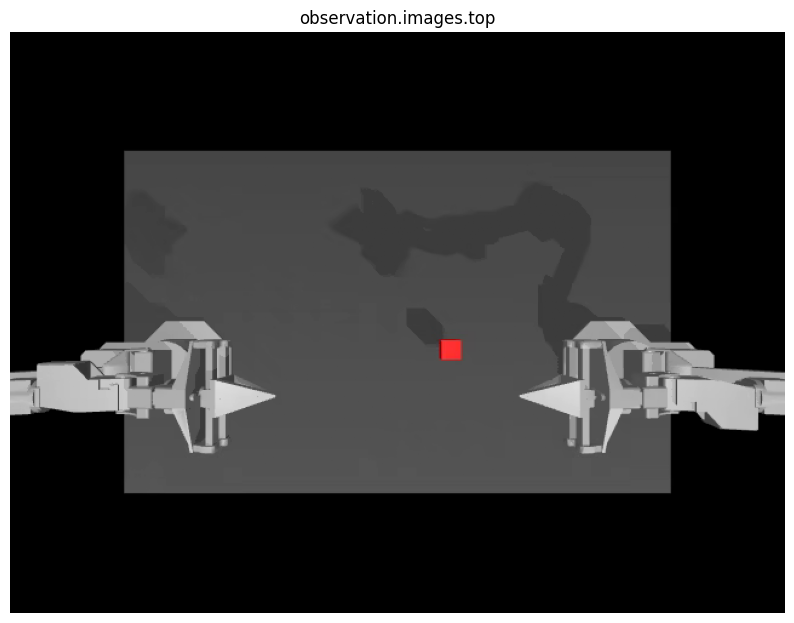

Displayed image shape: (480, 640, 3)


In [13]:
# View the "observation.images.top" entry in the first_row dict and display it
import matplotlib.pyplot as plt
import torch

# Access the image using the flat key structure
images_top = first_row.get("observation.images.top", None)

print()
print("=" * 80)
print("Shape and dtype of 'observation.images.top':")
if images_top is not None:
    # Convert tensor to numpy if needed
    if isinstance(images_top, torch.Tensor):
        img_array = images_top.numpy()
    elif isinstance(images_top, np.ndarray):
        img_array = images_top
    else:
        img_array = np.array(images_top)
    
    print(f"Shape: {img_array.shape}, dtype: {img_array.dtype}")
    print(f"Min value: {img_array.min()}, Max value: {img_array.max()}")
    
    # Handle different image formats
    if img_array.ndim == 4:  # (T, C, H, W) or (N, C, H, W)
        print(f"Sequence of images, first image shape: {img_array[0].shape}")
        img_to_display = img_array[0]
    elif img_array.ndim == 3:  # (C, H, W) or (H, W, C)
        print("Single image found.")
        img_to_display = img_array
    else:
        print(f"Unexpected shape: {img_array.shape}")
        img_to_display = None
    
    if img_to_display is not None:
        # Convert to displayable format (H, W, C) with values in [0, 1] or [0, 255]
        if img_to_display.ndim == 3:
            # Check if it's (C, H, W) or (H, W, C)
            if img_to_display.shape[0] == 3 or img_to_display.shape[0] == 1:
                # (C, H, W) -> (H, W, C)
                img_to_display = np.transpose(img_to_display, (1, 2, 0))
            
            # Handle grayscale
            if img_to_display.shape[2] == 1:
                img_to_display = img_to_display.squeeze(2)
        
        # Normalize to [0, 1] if needed
        if img_to_display.max() > 1.0:
            img_to_display = img_to_display / 255.0
        
        # Clip to [0, 1]
        img_to_display = np.clip(img_to_display, 0, 1)
        
        # Display the image
        plt.figure(figsize=(10, 8))
        if len(img_to_display.shape) == 2:
            plt.imshow(img_to_display, cmap='gray')
        else:
            plt.imshow(img_to_display)
        plt.title("observation.images.top")
        plt.axis('off')
        plt.show()
        
        print(f"Displayed image shape: {img_to_display.shape}")
else:
    print("'observation.images.top' not found in first_row.")
    print(f"Available keys: {list(first_row.keys())}")
print("=" * 80)


In [8]:

# # Sample actions from the model.
# loss = model.compute_loss(key, obs, act)

# # Delete the model to free up memory.
# del model

# print("Loss shape:", loss.shape)